# Clothes2Person

## Datasets:
https://github.com/shadow2496/VITON-HD?tab=readme-ov-file
11k pairs, with face (only lower body clothes, full body shot)
2k pairs, with face (only lower body clothes, full body shot)
datasource zalando

- 9k lower body (unfortunately only lower part of face visible (anonymized))
- 15k upper body (unfortunately only lower part of face visible (anonymized)) 
- 29k upper body (unfortunately only lower part of face visible (anonymized)) 
data source YOOX NET-A-PORTER


We use all data for training and use some new sampels for validation:
In-distribution Images from Zalando from the NEW tab (which should ensure these are new designs/ clothes the model has never seen)
Out of distribution images from Uniqlo from the NEW tab

The ControlNet architecture (https://arxiv.org/pdf/2302.05543):

The main idea of the ControlNet is to include a secondary input in addition to the main input for any model F. 
Then a frozen, locked, F(x, theta), and a copy of F(x, theta) (copy of the pretrained weights) are finetuned in conjunction to calculate y.
The layerwise activations of the copy are added through 1x1 convolutions to the main model. These convolutional layers are initialized at 0.
Thus initially, the whole model will compute using only F(x, theta), without the copy. This idea stabilizes the conditional finetuning approach: The weights of the initial F always stay locked and only the copied weights are finetuned in conjunction with the 1x1 convolutions:
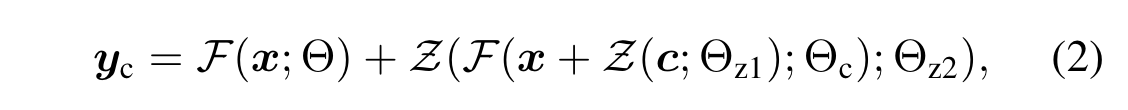

The authors apply the architecture to the Stable Diffusion architecture. In detail, only to the encoder and the middle part of U-Net component, which denoises the latents are copied. The duplicated encoder and middle part of the U-Net are added through skip connections with 1x1 convolutions to the middle part and decoder of the original U-Net. While the main U-Net is conditioned on the timestep and the encoded prompt, the new part which is finetuned can be conditioned on a image embedding C_f which is obtained by downscaling a conditional image by a small convolutional component with four layers from 512x512 to the size of the U-Net latents, 64x64. 

Working applications of ControlNet today are similar to the apple example, where the model is conditioned to follow a shape when composing a final image. Also multiple conditions can be 
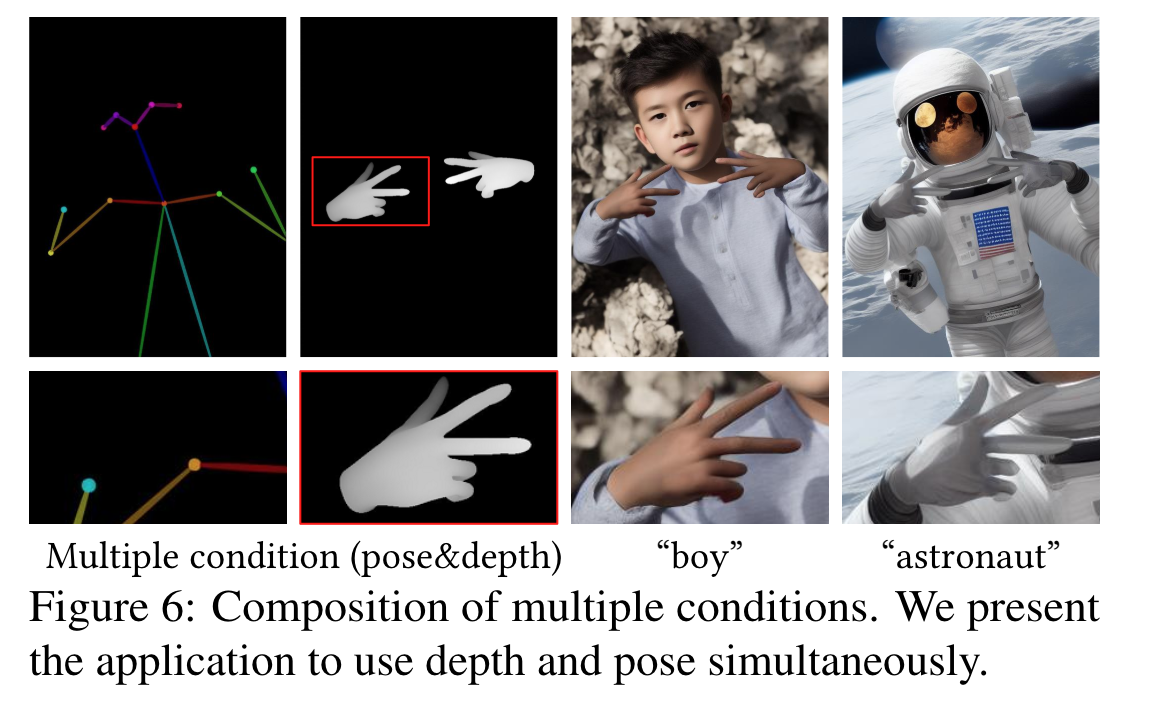

Some repository options for training ControlNet:
 - https://github.com/lllyasviel/ControlNet
    This is the official repository by one of the authors.
    Training is rather slow, but the author provides intuition on the training process.
    As observed over different training setups, ControlNet seems to have a point of convergence for the conventional ControlNet tasks like "depth-map2img", "lines2img" etc.: 
    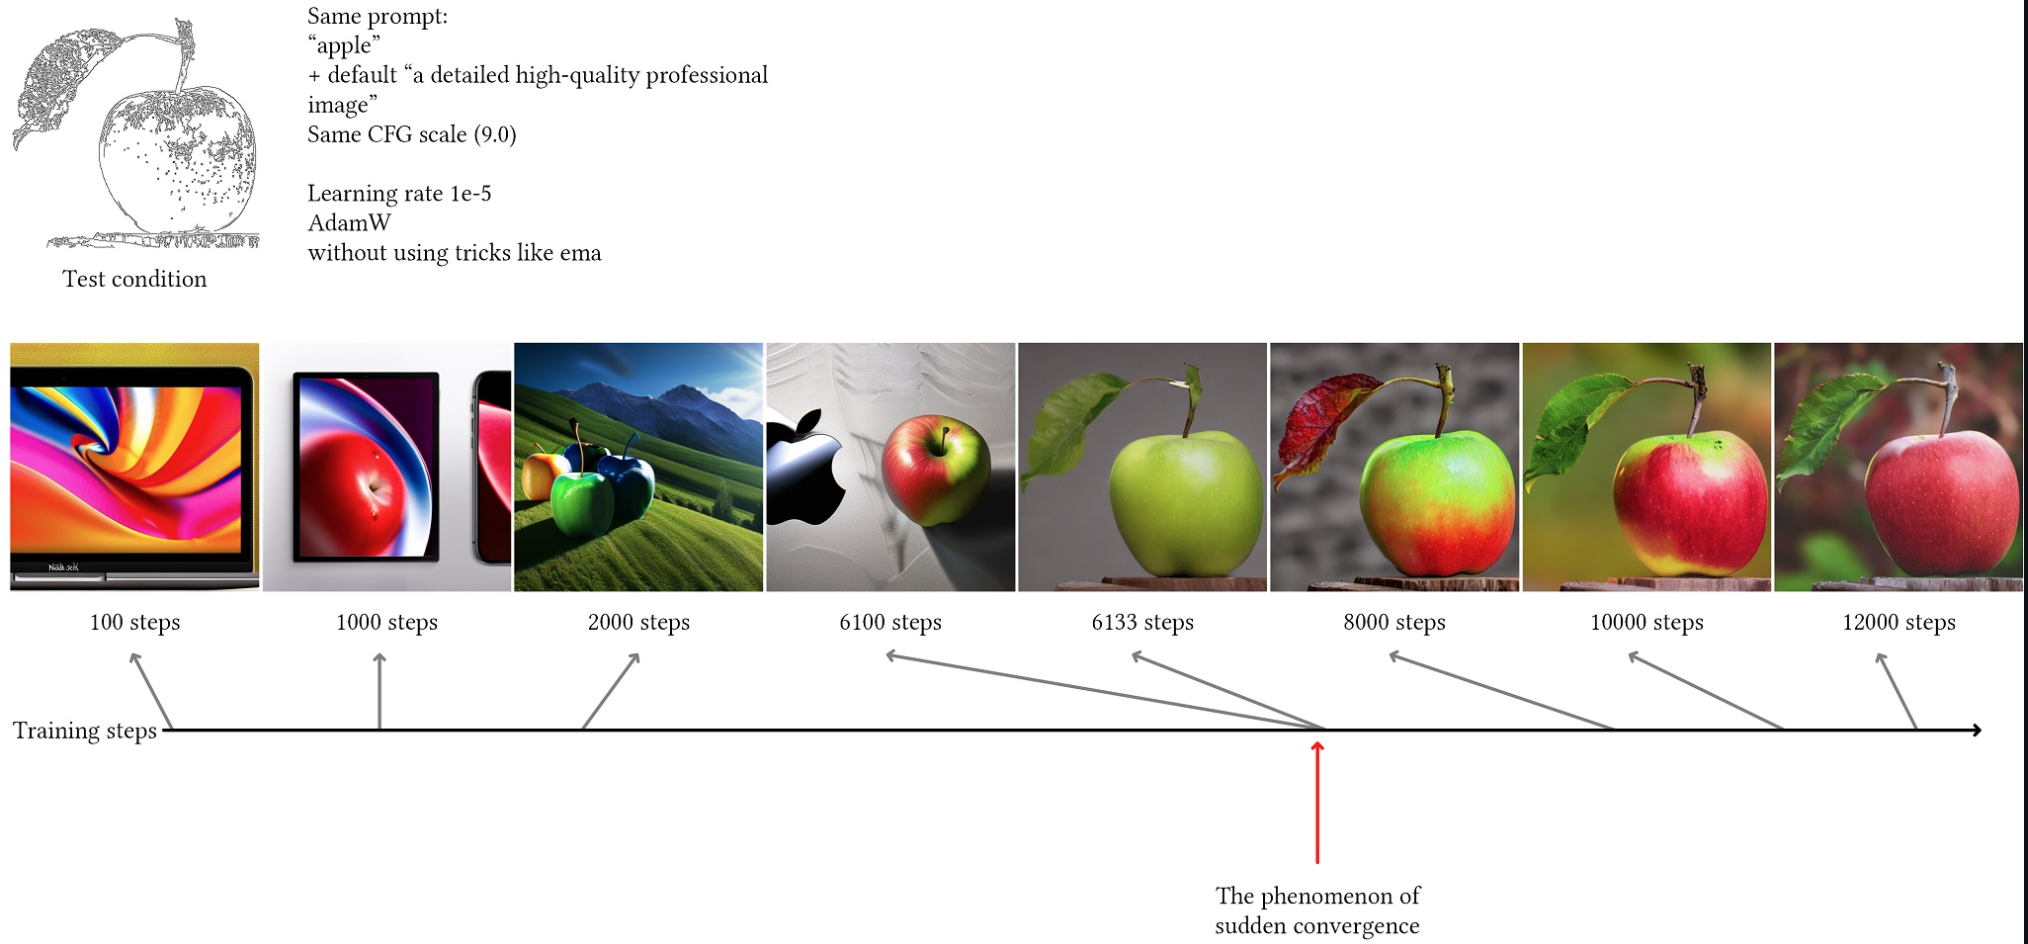 
    According to the author instead of training much further beyond the point of convergence it is better to train with larger batch size and a similar step amount to achieve more stable results: In this case training for 6000 steps (to the point of convergence) with doubled batchsize is better than training for 12000 steps with the original batch size.



The original ControlNet paper:

# Using the 16gb tutorial setup: 
# faster 9h/ 2.85s per iter
# Using 16gb + 12 gb --enable_xformers_memory_efficient_attention --set_grads_to_none is a lot slower
# Steps:   1%|        | 100/12500 [04:46<9:48:04,  2.85s/it, loss=0.0195, lr=1e-5
# so we use 16gb config
# use 2 T4 gpu:
# Steps:   1%|         | 13/2084 [03:11<8:16:03, 14.37s/it, loss=0.00271, lr=1e-5]
# can increase batchsize to 3 per node and 4 gradient accumulation steps: effectively batch size of 24
# - the code can achieve the speedup because of bitsandbites 8bitAdam, where we trade off speed for lower VRam usage
# - Gradient accumulation, only the compute graph is stored for each intermediate batch, after 4 batches gradients are jointly "backpropagated".
# -  therefore during the forward pass, only 1 of 4 batches is in memory simulatneously, which reduces the maximum memory usage and allows to train with larger effective batch sizes.
# According to the user https://github.com/lllyasviel (author of the original controlnet implementation for stable diffusion), training on larger batch sizes is prefered 
# to training for more steps. 
# batch size 24 is already 
# total of 50000 images,
# grad accumulation: 12500 steps, 
# 2 gpu: 6250 steps: 
# bs 3 instead of 1: 2084 steps


As reference, the repository https://github.com/lllyasviel/ControlNet is used. 

## Data Preprocessing
### Merging Viton HD and Dresscode datasets
We hope that the combination of both datasets will help the model to create higher quality output:
- The Viton HD lacks lower body examples, which the Dresscode dataset provides.
- The Dresscode datasets model faces are cut halfway (possibly for anonymization purposes) which the Viton HD dataset provides in full shot.

One strategy to prevent the model from associating spurious information from the clothes images with the specifics of both datasets respectively (e.g. face is (not) cut off), is to include these facts through the clip encoder through text.
- Therefore, the model can learn to associate the fact that the face is (not) cut of with the text "face (not) in frame". Since we desire the face to be in frame, during inference we can use the appropriate text.
- Similarly, describing the output image with text, except for the clothing which is supplied as input image, could help the model to learn associations more appropriately. This is one variant we experiment with. Text descriptions can be supplied with OpenAI's BLIP or CLIP

In [ ]:
from PIL import Image
